In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import re

In [2]:
saveFigures=False

In [3]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

In [4]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

# Build Model: Density

Import feature set, import data

In [5]:
with gzip.open('./datasets/density_features.pkl.gz', 'rb') as fp:
    X_dens = pkl.load(fp)
with gzip.open('./datasets/density_data.pkl.gz', 'rb') as fd:
    densityData = pkl.load(fd)

In [6]:
density_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [7]:
%%time
density_model.fit(X_dens, y=densityData['density'])

Wall time: 390 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [8]:
# Export for testing with MAPI data?
with gzip.open('./datasets/MG_density_model.pkl.gz', 'wb') as fp:
    pkl.dump(density_model, fp)

In [9]:
print(np.shape(X_dens)) # should be (701 x 152)
print(len(density_model.steps[1][1].feature_importances_)) # should be 152
print(len(dens_featurizer.feature_labels())) # should be 152

(701, 152)
152
152


In [10]:
# Look at feature importances when trained on the whole data set
featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
# featureImp.to_csv(os.path.join(os.getcwd(),'results','defaultDensityModel_features.csv'))

In [11]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

# Generate learning curves, assess initial quality of model

In [12]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_dens, densityData['density'], cv=ShuffleSplit(),
                                                          scoring=r2_scorer)

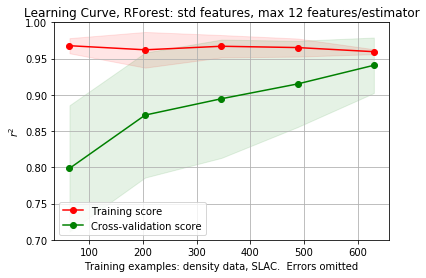

In [13]:
plt.figure()
plt.title('Learning Curve, RForest: std features, max 12 features/estimator')
plt.xlabel("Training examples: density data, SLAC.  Errors omitted")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.ylim([0.7, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v1.0_LearningCurve.png'))
    print('figure saved')

In [14]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
densityData['density_predict'] = np.nan
for train_index, test_index in kf.split(densityData['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_dens[train_index,:], densityData['density'][train_index])
    
    y_densPredict = density_model.predict(X_dens[test_index,:])
    densityData['density_predict'][test_index] = y_densPredict
    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


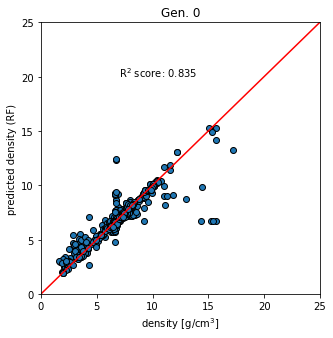

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')

r2Std = r2_score(densityData['density'], densityData['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2Std))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 0')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v0_Scatter.png'))
    print('figure saved')

Compare to Vegard's law, rule of mixtures

In [16]:
densityData['density_vegards'] = np.nan
densityData['density_vegards'] = [vegardsDensity(c) for c in densityData['comp']]
densityData['vegards_diff'] = densityData['density'] - densityData['density_vegards']

In [17]:
#densityData['density_vegards'] = pd.Series([vegardsDensity(comp) for comp in densityData['comp']])
r2Vegards = r2_score(densityData['density'],densityData['density_vegards'])
r2RF = r2_score(densityData['density'], densityData['density_predict'])
print('Vegards: {}, Random Forest Regressor: {}'.format(r2Vegards, r2RF))

Vegards: 0.8614466511737545, Random Forest Regressor: 0.834774621570455


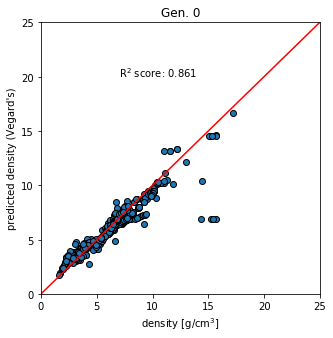

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 0')

r2V = r2_score(densityData['density'], densityData['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v0_Vegards_Scatter.png'))
    print('figure saved')

# Investigating poorly performing predictions

In [19]:
largeErrorDensity = densityData[ [ (abs((x-y)) > 2)&(x>10) for x,y in zip(densityData['density'], densityData['density_predict']) ]]
for comp in largeErrorDensity['comp']:
    print(comp)

Cu1.5 Si1.5 Ag0.3 B4 P18 Pt74.7
Ta21 Co11 Ni18
Hf62 Al13 Ni9.75
Hf46 Nb2 Al13 Cu29.25 Ni9.75
Hf49 Ta2 Al12 Cu27.75 Ni9.25
Fe9 P5 Pt6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6
Zr57 Nb5 Al10 Cu15.4 Ni12.6


In [20]:
compTrouble = Composition('Zr57 Nb5 Al10 Cu15.4 Ni12.6')
densityData[ [compTrouble.almost_equals(c) for c in densityData['comp']] ]

,comp,density,density_predict,density_vegards,vegards_diff
155,"(Zr, Nb, Al, Cu, Ni)",6.758,12.330885,6.91044,-0.15244
458,"(Zr, Nb, Al, Cu, Ni)",6.69,12.400876,6.91044,-0.22044
606,"(Zr, Nb, Al, Cu, Ni)",15.2,6.715432,6.91044,8.28956
607,"(Zr, Nb, Al, Cu, Ni)",14.3,6.715432,6.91044,7.38956
608,"(Zr, Nb, Al, Cu, Ni)",15.67,6.715432,6.91044,8.75956
609,"(Zr, Nb, Al, Cu, Ni)",15.44,6.715432,6.91044,8.52956
615,"(Zr, Nb, Al, Cu, Ni)",6.68,6.715432,6.91044,-0.23044


error std: 0.8400961959128355, error mean: 0.16131624945023973


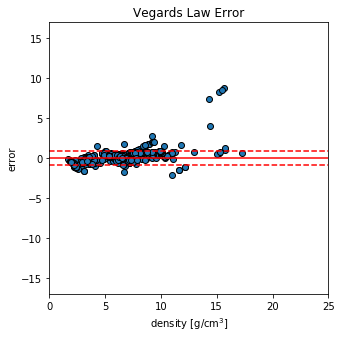

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(densityData['density'], densityData['vegards_diff'], edgecolors='k')
plt.plot([0,25], [0,0], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('error')
plt.title('Vegards Law Error')

stddev = np.std(densityData['vegards_diff'])
mean = np.mean(densityData['vegards_diff'])
plt.plot([0, 25], [stddev, stddev], 'r--')
plt.plot([0, 25], [-stddev, -stddev], 'r--')

plt.xlim([0,25])
plt.ylim([-17,17])

print('error std: {}, error mean: {}'.format(stddev, mean))

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v0_Vegards_Error.png'))
    print('figure saved')

In [22]:
len(densityData)/60

11.683333333333334

error std: 0.8400961959128355, error mean: 0.16131624945023973


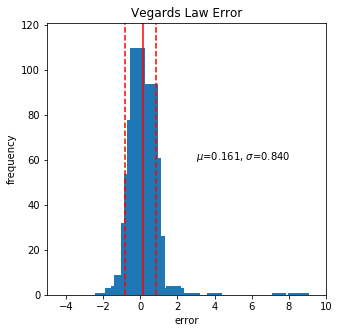

In [23]:
plt.figure(figsize=(5,5))
n, bins = np.histogram(densityData['vegards_diff'].values, bins='auto')

binCenter = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

plt.bar(binCenter, n)

plt.xlabel('error')
plt.ylabel('frequency')
plt.title('Vegards Law Error')

plt.xlim([-5,10])
plt.ylim([0,1.1*np.max(n)])

stddev = np.std(densityData['vegards_diff'])
mean = np.mean(densityData['vegards_diff'])
plt.plot([mean, mean], [0, 1.2*np.max(n)], 'r')
plt.plot([stddev, stddev], [0, 1.2*np.max(n)], 'r--')
plt.plot([-stddev, -stddev], [0, 1.2*np.max(n)], 'r--')

plt.text(3,60, '$\mu$={:.3f}, $\sigma$={:.3f}'.format(mean, stddev))
print('error std: {}, error mean: {}'.format(stddev, mean))


if saveFigures:
    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v0_Vegards_Error_hist.png'))
    print('figure saved')

Why would the same composition be predicted differently?  For the same composition one should get the same features, yet the predicted density varies.  This is also true for the previous predictions.  

Should probably depend on the specific split used to train the model

In [24]:
# Drop troublesome compositions
X_notTrouble = X_dens[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]

In [25]:
#  Examine performance without outliers (trouble compositions)
notTroubleDF = densityData[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]
notTroubleDF.reset_index(inplace=True, drop=True)

#  Examine performance without outliers in normal model
print('Density Prediction, r2 sans outliers: {}'.format(r2_score(notTroubleDF['density_predict'], notTroubleDF['density'])))

Density Prediction, r2 sans outliers: 0.9075911576494425


In [26]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
impDF = pd.DataFrame()

kf = KFold(5)
rep=0
notTroubleDF['density_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['density_predict'][test_index] = y_densPredict
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    impDF = impDF.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


In [27]:
impDF['totalImp'] = impDF.groupby(level=0)['importance'].transform('sum')
impDFtop = impDF.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
impDFtop.to_csv(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v1_featImportance.csv'))
impDFtop.head()

top features over 5 training splits


,importance,totalImp
mode Number,0.052223,0.300349
mean NValence,0.057423,0.288853
mode AtomicWeight,0.038915,0.255935
mode NValence,0.042134,0.246298
mean Number,0.018850,0.221519


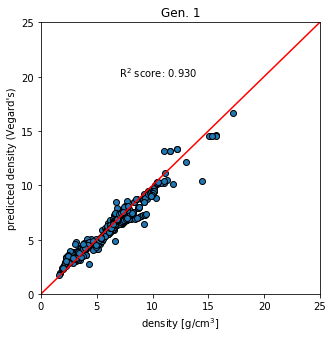

In [28]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 1')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v1_Vegards_Scatter.png'))
    print('figure saved')

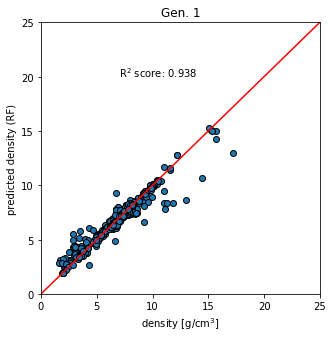

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')
plt.title('Gen. 1')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_predict'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v1_Scatter.png'))
    print('figure saved')

# Alternate Feature Set, from rfecv and covariance matrix

['maximum NsValence', 'minimum NpValence', 'minimum NfValence', 'minimum NsUnfilled', 'minimum NpUnfilled', 'minimum NfUnfilled', 'minimum GSbandgap', 'mode GSbandgap', 'compound possible']


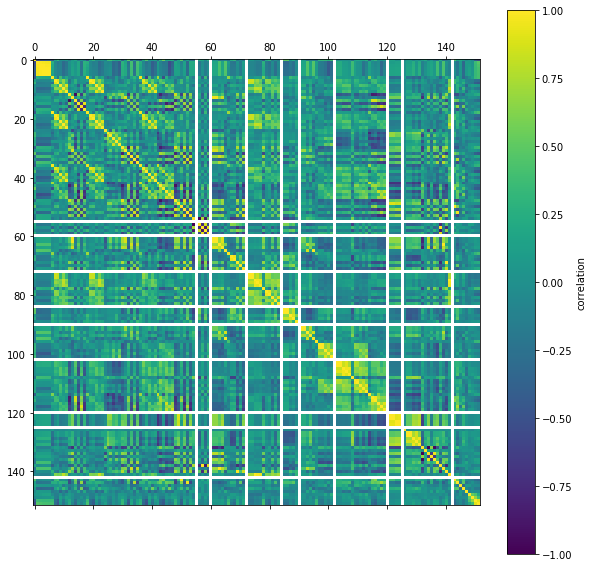

In [30]:
# Look at feature correlations..
X_densDF = pd.DataFrame(X_dens, columns=dens_featurizer.feature_labels())
correlations = X_densDF.corr()  # Returns NaN if values do not vary at all...

# find columns that do not vary
invariants =[ col for col in correlations.columns if correlations[col].isnull().all() ]
print(invariants)

# plot covariance matrix
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax, label='correlation')

In [31]:
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape),k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
print('----------------------------correlated features to drop')
print(to_drop)
print('----------------------------invariants:')
print(invariants)

----------------------------correlated features to drop
['3-norm', '5-norm', '7-norm', '10-norm', 'minimum AtomicWeight', 'maximum AtomicWeight', 'range AtomicWeight', 'mean AtomicWeight', 'avg_dev AtomicWeight', 'mode AtomicWeight', 'minimum Row', 'mean Row', 'mode Row', 'maximum NpValence', 'range NpValence', 'range NdValence', 'range NfValence', 'avg_dev NfValence', 'mode NfValence', 'range NValence', 'range NsUnfilled', 'range NpUnfilled', 'mode NpUnfilled', 'range NdUnfilled', 'range NfUnfilled', 'avg_dev NfUnfilled', 'mode NfUnfilled', 'range NUnfilled', 'range GSvolume_pa', 'range GSbandgap', 'avg_dev GSbandgap', 'range GSmagmom', 'mode GSmagmom', 'avg s valence electrons', 'avg p valence electrons', 'avg d valence electrons', 'avg f valence electrons', 'max ionic char', 'avg ionic char']
----------------------------invariants:
['maximum NsValence', 'minimum NpValence', 'minimum NfValence', 'minimum NsUnfilled', 'minimum NpUnfilled', 'minimum NfUnfilled', 'minimum GSbandgap', 'm

In [32]:
len(to_drop)

39

In [33]:
feat = 'mean GSbandgap'
upper.loc[feat][upper.loc[feat]>0.5]
#returns other features fitting the covariance condition.  (queries rows of cov matrix)

avg_dev GSbandgap           0.997949
maximum GSmagmom            0.510955
range GSmagmom              0.510955
mean GSmagmom               0.741110
avg_dev GSmagmom            0.723227
mode GSmagmom               0.796498
range SpaceGroupNumber      0.628599
avg_dev SpaceGroupNumber    0.552631
mode SpaceGroupNumber       0.604314
avg p valence electrons     0.531445
Name: mean GSbandgap, dtype: float64

In [49]:
%%time
# Try recursive feature elimination
RF = RandomForestRegressor(n_estimators=100, n_jobs=1)

rfecv = RFECV(estimator=RF, step=2, cv=KFold(5),
              scoring=r2_scorer)
if True: # Takes forever
    rfecv.fit(X_dens, densityData['density']) 

Wall time: 9min 53s


Optimal number of features : 30


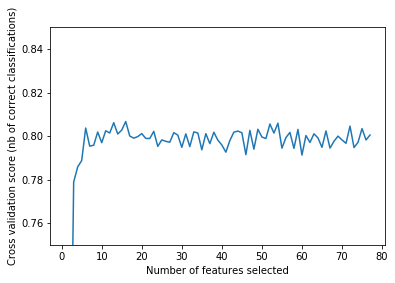

In [50]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.ylim([0.75, 0.85])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v1_rfecv.png'))
    print('figure saved')

In [51]:
# Combine data: original feature order, feature rankings by rfecv
feats = pd.DataFrame(dens_featurizer.feature_labels(), columns=['feat_name'])
feats['orig_order'] = range(len(feats))
feats['rfecv_ranking'] = rfecv.ranking_

# Mark features to drop
feats['to_remove'] = 0
feats['to_remove'] = [1 if feats['feat_name'][x] in to_drop+invariants else 0 for x in range(len(feats))]

In [52]:
# take all features ok'd (not dropped due to covariance or invariance
feats_subset = feats[feats['to_remove']==0]

feats_subset.sort_values(by='rfecv_ranking',inplace=True)
feats_subset.reset_index(drop=True, inplace=True)

# Create new feature matrix and list of features (differently ordered from original featurizer)
X_subset = X_notTrouble[:,feats_subset['orig_order'][:rfecv.n_features_].tolist()]
reduced_feats = feats_subset['feat_name'][:rfecv.n_features_]

### After feature reduction, try re-evaluating model performance

In [53]:
densModel_elimFeats = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [54]:
#take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
impDF = pd.DataFrame()

kf = KFold(5)
rep=0
notTroubleDF['density_predict_rfecv'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    densModel_elimFeats.fit(X_subset[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = densModel_elimFeats.predict(X_subset[test_index,:])
    notTroubleDF['density_predict_rfecv'][test_index] = y_densPredict
    
    featureImp = pd.DataFrame(densModel_elimFeats.steps[1][1].feature_importances_,
                          index=reduced_feats,
                          columns=['importance']).sort_values('importance',ascending=False)
    impDF = impDF.append(featureImp)
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


In [55]:
impDF['totalImp'] = impDF.groupby(level=0)['importance'].transform('sum')
impDFtop = impDF.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
impDFtop.to_csv(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v2_featImportance.csv'))
impDFtop.head()

top features over 5 training splits


,importance,totalImp
feat_name,,
mode NValence,0.195739,0.940237
mode Number,0.067177,0.916297
mean NValence,0.171629,0.663548
mean Electronegativity,0.093666,0.361777
mean Number,0.031258,0.275884


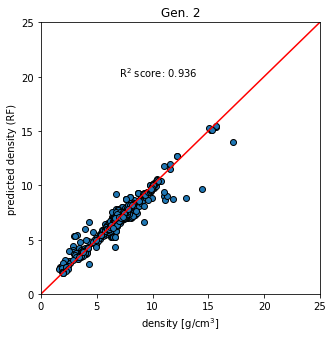

In [56]:
# plot Comparison, report r2
r2rfecv = r2_score(notTroubleDF['density'], notTroubleDF['density_predict_rfecv'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict_rfecv'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (RF)')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2rfecv))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 2')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v2_Scatter.png'))
    print('figure saved')

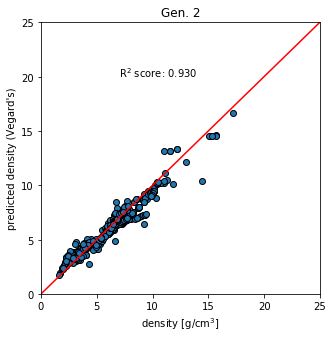

In [57]:
plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s)')
plt.title('Gen. 2')

r2V = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])
plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2V))

plt.xlim([0,25])
plt.ylim([0,25])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v2_Vegards_Scatter.png'))
    print('figure saved')

# Train model on difference from Vegards Predictions

In [58]:
print('mean difference: {:.3f}, variance {:.3f}'.format(densityData['vegards_diff'].mean(), densityData['vegards_diff'].var()))
print('max difference: {:.3f}, min difference {:.3f}'.format(densityData['vegards_diff'].max(), densityData['vegards_diff'].min()))

mean difference: 0.161, variance 0.707
max difference: 8.760, min difference -2.111


In [59]:
densDiffModel = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

In [60]:
%%time
densDiffModel.fit(X_dens, densityData['vegards_diff'])

Wall time: 374 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

Make sure is true

See if there's any learning at all 

Everything else must be process dependant, experimental, bad data, etc

## Train on difference between density and vegards, see what features float up
Not including outliers

In [61]:
notTroubleDF.head()

,comp,density,density_predict,density_vegards,vegards_diff,density_predict_rfecv
0,"(Ce, Al)",3.462,4.057876,3.1070,0.355,3.936705
1,"(Al, Fe, B)",3.539,5.809120,3.6620,-0.123,4.743269
2,"(Zr, Al, Ni)",3.384,3.895027,3.5105,-0.1265,4.059783
3,"(Zr, Al, Ni)",3.517,3.999587,3.6965,-0.1795,4.178260
4,"(Hf, Al, Ni)",2.835,5.478570,3.8505,-1.0155,4.376186


Need to RFECV with this dataset independently

In [88]:
%%time
# Try recursive feature elimination
RF = RandomForestRegressor(n_estimators=100, n_jobs=1)

rfecv_diff = RFECV(estimator=RF, step=2, cv=KFold(5),
              scoring=r2_scorer)
if True: # Takes forever
    rfecv_diff.fit(X_dens, densityData['vegards_diff']) 

Wall time: 10min 3s


Optimal number of features : 74


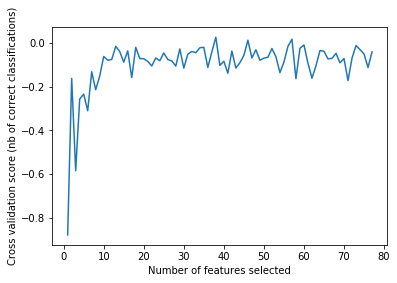

In [89]:
print("Optimal number of features : %d" % rfecv_diff.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_diff.grid_scores_) + 1), rfecv_diff.grid_scores_)
#plt.ylim([0.75, 0.85])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs', 
                             'densityMG-v3_rfecv.png'))
    print('figure saved')

In [90]:
# Combine data: original feature order, feature rankings by rfecv
feats_diff = pd.DataFrame(dens_featurizer.feature_labels(), columns=['feat_name'])
feats_diff['orig_order'] = range(len(feats_diff))
feats_diff['rfecv_ranking'] = rfecv_diff.ranking_

# Mark features to drop
feats_diff['to_remove'] = 0
feats_diff['to_remove'] = [1 if feats_diff['feat_name'][x] in to_drop+invariants else 0 for x in range(len(feats_diff))]

# take all features ok'd (not dropped due to covariance or invariance
feats_diff_subset = feats_diff[feats_diff['to_remove']==0]

feats_diff_subset.sort_values(by='rfecv_ranking',inplace=True)
feats_diff_subset.reset_index(drop=True, inplace=True)

# Create new feature matrix and list of features (differently ordered from original featurizer)
X_diff_subset = X_notTrouble[:,feats_diff_subset['orig_order'][:rfecv_diff.n_features_].tolist()]
reduced_feats_diff = feats_diff_subset['feat_name'][:rfecv_diff.n_features_]

In [91]:
# Train on difference
diffFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['diff_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_diff_subset[train_index,:], notTroubleDF['vegards_diff'][train_index])
    
    y_diffPredict = density_model.predict(X_diff_subset[test_index,:])
    notTroubleDF['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=reduced_feats_diff,
                          columns=['importance']).sort_values('importance',ascending=False)
    print(featureImp.head())
    
    diffFeatTop5 = diffFeatTop5.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 555
                        importance
feat_name                         
minimum CovalentRadius    0.090222
mean NpValence            0.052912
avg_dev Column            0.043513
mean CovalentRadius       0.039461
mean GSbandgap            0.034925
Split #1, training on 555
                        importance
feat_name                         
minimum CovalentRadius    0.055082
avg_dev NpValence         0.043464
avg_dev Column            0.043173
minimum GSvolume_pa       0.041328
mode MeltingT             0.036597
Split #2, training on 555
                        importance
feat_name                         
avg_dev Column            0.106061
minimum CovalentRadius    0.091468
mean GSbandgap            0.056466
mean Electronegativity    0.037023
mean CovalentRadius       0.034887
Split #3, training on 555
                           importance
feat_name                            
minimum CovalentRadius       0.063427
mean SpaceGroupNumber        0.047460
avg_dev R

In [92]:
diffFeatTop5['totalImp'] = diffFeatTop5.groupby(level=0)['importance'].transform('sum')
diffFeatTop = diffFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
diffFeatTop.to_csv(os.path.join(os.getcwd(),'results', 'finalFigs',
                                'densityMG-v3_featImportance_190319_4.csv'))
diffFeatTop.head()

top features over 5 training splits


,importance,totalImp
feat_name,,
minimum CovalentRadius,0.090222,0.359628
avg_dev Column,0.043513,0.257590
mean GSbandgap,0.034925,0.190607
avg_dev GSmagmom,0.033573,0.161952
minimum GSvolume_pa,0.014008,0.159870


In [ ]:
# plot Comparison, report r2
r2noOutDiff = r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'], edgecolors='k')
plt.plot([-5,5], [-5,5], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-1,4, 'R$^2$ score: {:.3f}'.format(r2noOutDiff))
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Pre-Gen. 3')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v3_differenceScatter.png'))
    print('figure saved')

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(density_model, X_subset, notTroubleDF['vegards_diff'], 
                                                                    cv=ShuffleSplit(), scoring=r2_scorer)

In [ ]:
plt.figure()
plt.title('Default feats, deviation from Vegards')
plt.xlabel("Training examples: density data, SLAC")
plt.ylabel("$r^2$")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc=4)
#plt.ylim([0.4, 1])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(), 'results', 'finalFigs',
                             'densityMG-v2.0_LearningCurve.png'))
    print('saved figure')

In [ ]:
# Look at mean absolute err with this new data set:

mae = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_predict'])
mae_vegards = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_vegards'])
print('MAE for random forest: {:.4f} vs vegards law {:.4f}'.format(mae, mae_vegards))
mae_diff = mean_absolute_error(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])
print(mae_diff)

# Assess performance of using difference predictions instead of full model 

In [ ]:
notTroubleDF['vPlusDiff'] = notTroubleDF['density_vegards'] + notTroubleDF['diff_predict']
r2Comp = r2_score(notTroubleDF['density'], notTroubleDF['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vPlusDiff'], notTroubleDF['density'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density (Vegard\'s + difference)')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Gen. 3')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-v3_Scatter.png'))
    print('figure saved')

# Try to predict Vegard's law directly

In [ ]:
# Train on difference
vegardFeats = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['vegards_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_subset[train_index,:], notTroubleDF['density_vegards'][train_index])
    
    y_pred = density_model.predict(X_subset[test_index,:])
    notTroubleDF['vegards_predict'][test_index] = y_pred
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=reduced_feats,
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    vegardFeats = vegardFeats.append(featureImp)

    rep+=1

In [ ]:
# Sort and compile importances
vegardFeats['totalImp'] = vegardFeats.groupby(level=0)['importance'].transform('sum')
vegardFeats = vegardFeats.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
vegardFeats.to_csv(os.path.join(os.getcwd(),'results','densityMG-Vegards_featureImportance.csv'))
vegardFeats.head()

In [ ]:
r2Veg = r2_score(notTroubleDF['density_vegards'], notTroubleDF['vegards_predict'])
print(r2Veg)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_predict'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('Vegards predicted density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Veg))
plt.xlim([0,25])
plt.ylim([0,25])
#plt.title('')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','finalFigs',
                             'densityMG-Vegards_predictScatter.png'))
    print('figure saved')

In [ ]:
# Once satisfied with feature set, overwrite original datasets?

with gzip.open('./datasets/density_features_subset.pkl.gz', 'wb') as fp:
    pkl.dump(X_subset, fp)
with gzip.open('./datasets/density_data_subset.pkl.gz', 'wb') as fd:
    pkl.dump(notTroubleDF, fd)
with gzip.open('./datasets/reduced_feats.pkl.gz', 'wb') as fr:
    pkl.dump(reduced_feats, fr)

# Restrict to 12 Features with varying importance
Omitting outliers
Compare to best model: Vegards+Difference predictions
ref: Jae/Nils attempts

In [ ]:
varyFeatData = notTroubleDF[['comp', 'density', 'density_vegards', 'vegards_diff','vPlusDiff']]
varyFeatData.head()

In [ ]:
#Train density_model on all data several times, get consistently performing features
featListSorted = pd.DataFrame()

kf = KFold(5)
rep=0
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
   
    topFeats = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance', ascending=False)
    
    featListSorted = featListSorted.append(topFeats)
    rep += 1
    
    
featListSorted['totalImp'] = featListSorted.groupby(level=0)['importance'].transform('sum')
featListSorted = featListSorted.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits:')
featListSorted.head()

In [ ]:
featList = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance'])
featList.reset_index(inplace=True)

In [ ]:
#diffFeatTop
#densFeatTop
# Gather default ordering of features
#featList = pd.DataFrame(density_model.steps[1][1].feature_importances_,
#                          index=dens_featurizer.feature_labels(),
#                          columns=['importance'])
#featList.reset_index(inplace=True)

scoreDict = {}
colList = []

for n in range(0, len(featList)-20, 5):
    # Grab n to n+12th most important features
    featIndex = featList[ [x in diffFeatTop.iloc[n:n+20].index for x in featList['index']] ].index.values

    X_temp = X_notTrouble[:, featIndex]

    # Begin training with 5-fold CV
    kf = KFold(5)
    rep=0
    
    scoreDict[n] = []
    print('--------------------------------------------------------')
    for train_index, test_index in kf.split(varyFeatData['comp']):
        # String for column name
        colStr = 'n{}Part{}_predict'.format(n, rep)
        colList.append(colStr)
        
        print('Split #{}, training on {}: {}'.format(rep, len(train_index), colStr))
        
        varyFeatData[colStr] = np.nan    
        
        density_model.fit(X_temp[train_index,:], varyFeatData['density'][train_index])

        y_pred = density_model.predict(X_temp[test_index,:])
        varyFeatData[colStr][test_index] = y_pred

        #print(train_index, test_index)
        rep+=1
   

In [ ]:
varyFeatData.head()

In [ ]:
for name in colList:
    num = int(re.search('n(\d*)Part*', name)[1])
    currSplit = varyFeatData[ ~varyFeatData[name].apply(np.isnan) ]
    scoreDict[num].append( r2_score(currSplit['density'], currSplit[name]))
    
#print('avg: {}, std: {}'.format(np.mean(scores),np.std(scores)))

In [ ]:
ns = []
avgs = []
meds = []
stds = []
mins = []
for key, item in scoreDict.items():
    ns.append(key)
    avgs.append(np.mean(item))
    meds.append(np.median(item))
    stds.append(np.std(item))
    mins.append(np.min(item))

In [ ]:
ns = np.array(ns)
avgs = np.array(avgs)
meds = np.array(meds)
stds = np.array(stds)
mins = np.array(mins)

In [ ]:
plt.figure()

plt.title('Performance with 20 features')
plt.xlabel('n where nth to n+20th most important feats used')
plt.ylabel('r$^2$ score')

plt.fill_between(ns, avgs - stds,
                 avgs + stds, alpha=0.1,
                 color="r")
plt.plot(ns, avgs, 'o-', color="r", label='mean')
plt.plot(ns, mins, 's-', color='g', label='min')
plt.plot([-5,ns[-1]+5], [0, 0], '--', color='k')
plt.legend(loc='lower left')

plt.xlim([-5,ns[-1]+5])

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','featElim_20_noOut.png'))
    print('figure saved')

In [ ]:
# Sum importances
featListSorted['cumSum_totalImp'] = featListSorted['totalImp'].cumsum()/5

In [ ]:
plt.figure()

plt.plot(range(len(featListSorted)), featListSorted['cumSum_totalImp'])
plt.ylabel('Cumulative Feature Importance')
plt.xlabel('n most important features')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','cumSum_FeatImp.png'))
    print('figure saved')

In [57]:
reduced_feats

0                       maximum MeltingT
1                       mode GSvolume_pa
2                 mean Electronegativity
3                         mean NUnfilled
4                            mean Column
5                  mean SpaceGroupNumber
6               avg_dev SpaceGroupNumber
7                          mode MeltingT
8                       avg_dev MeltingT
9                          mean MeltingT
10                        range MeltingT
11                   mode CovalentRadius
12                     avg_dev NUnfilled
13                        mean NsValence
14               avg_dev MendeleevNumber
15                         mode NValence
16                      avg_dev NValence
17                         mean NValence
18               minimum MendeleevNumber
19                           mode Number
20                           mean Number
21        mean simul. packing efficiency
22                      maximum NValence
23                        mean NfValence
24              